In [8]:
import numpy as np
import os
import datetime as datetime
import pandas as pd
import matplotlib.pyplot as plt


os.system('source /home/jackalak/heartbeat/cdf38_0-dist/bin/definitions.B')
os.environ["CDF_LIB"] = '/home/jackalak/heartbeat/cdf38_0-dist/lib'
from spacepy import pycdf

from ovationpyme.ovation_prime import FluxEstimator,AverageEnergyEstimator,BinCorrector
from ovationpyme.ovation_utilities import calc_avg_solarwind
from ovationpyme.ovation_plotting import latlt2polar,polar2dial,pcolor_flux

import numpy as np
import pandas as pd
from datetime import timedelta

from nasaomnireader import omnireader

import ftplib
import os

import datetime as datetime
import pickle
import glob
import tensorflow as tf
from tensorflow import keras
import datetime

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
import tensorflow

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout
from sklearn import preprocessing
import tensorflow.keras.backend as K


import datetime
from os.path import isfile, join
from sys import getsizeof
from random import *

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Input

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [9]:
def download_omni_data(t_start, t_end):

    #--------------------------------------------------------#
    #	OMNI Data - includes solar wind, and geomag params   #
    #--------------------------------------------------------#

    #get OMNI data
    omniInt = omnireader.omni_interval(t_start,t_end,'5min', cdf_or_txt = 'txt')

    #print(omniInt.cdfs[0].vars) #prints all the variables available on omni

    epochs = omniInt['Epoch'] #time array for omni 5min data
    By,Bz,AE,SymH = omniInt['BY_GSM'],omniInt['BZ_GSM'],omniInt['AE_INDEX'], omniInt['SYM_H']
    AL, AU = omniInt['AL_INDEX'],omniInt['AU_INDEX']
    vsw,psw = omniInt['flow_speed'], omniInt['Pressure']
    borovsky_reader = omnireader.borovsky(omniInt)
    borovsky = borovsky_reader()
    #newell_reader = omnireader.newell(omniInt)
    #newell = newell_reader()

    def NewellCF_calc(v,bz,by):
        # v expected in km/s
        # b's expected in nT    
        NCF = np.zeros_like(v)
        NCF.fill(np.nan)
        bt = np.sqrt(by**2 + bz**2)
        bztemp = bz
        bztemp[bz == 0] = .001
        #Caculate clock angle (theta_c = t_c)
        tc = np.arctan2(by,bztemp)
        neg_tc = bt*np.cos(tc)*bz < 0 
        tc[neg_tc] = tc[neg_tc] + np.pi
        sintc = np.abs(np.sin(tc/2.))
        NCF = (v**1.33333)*(sintc**2.66667)*(bt**0.66667)
        return NCF


    newell = NewellCF_calc(vsw, Bz, By)


    # 	proton_flux_10MeV, proton_flux_30MeV, proton_flux_60MeV = omniInt['PR-FLX_10'], omniInt['PR-FLX_30'], omniInt['PR-FLX_60']


    #calculate clock angle
    clock_angle = np.degrees(np.arctan2( By,Bz))
    clock_angle[clock_angle < 0] = clock_angle[clock_angle<0] + 360.

    #print('Got 5 minutes data')

    omniInt_1hr = omnireader.omni_interval(t_start,t_end,'hourly', cdf_or_txt = 'txt')
    F107,KP = omniInt_1hr['F10_INDEX'], omniInt_1hr['KP']
    KP = pd.DataFrame(np.repeat(KP,12,axis=0))
    F107 = pd.DataFrame(np.repeat(F107,12,axis=0))



    #put all in a dataframe and save

    dataframe = pd.DataFrame()
    dataframe['Bz'] = Bz
    dataframe['By'] = By
    dataframe['Vsw'] = vsw
    dataframe['Vx'] = omniInt['Vx']
    dataframe['Psw'] = psw
    dataframe['AE'] = AE
    dataframe['AL'] = AL
    dataframe['AU'] = AU
    dataframe['SymH'] = SymH
    dataframe['Clock Angle'] = clock_angle
    dataframe['newell'] = newell
    dataframe['borovsky'] = borovsky
    dataframe['Kp'] = KP
    dataframe['F107'] = F107
    dataframe['PC'] = omniInt['PC_N_INDEX']
    dataframe['Bx'] = omniInt['BX_GSE']
    # 	dataframe = dataframe.replace(9999.99, np.nan) #replace 9999.99 with nans ??????????????

    return dataframe

from datetime import timedelta

# In[2]:


class t_hist():
    '''
    Class which takes solar wind data and creates some time history
    for some specific time.
    
    Input:
        Data ---------- A DataFrame of solar wind data at 5 minute
                        cadence and datetime index.
        Historic_time - The number of minutes into the past you
                        would like the hisotry for. (E.g. for 1hr ago
                        you would input 60 minutes).
        window_mins --- If averaging for the time history, then this
                        input specifies the window length, in minutes,
                        centred on the historic_time specified.
    '''
    def __init__(self,data,historic_time,window_mins):
        self.data = data
        self.time = historic_time
        self.window = window_mins
        
    def avg_hist(self):
        '''
        Function which returns a historic_time value, averaged over
        the window_mins.
        
        Output:
            - A dataframe of values of the time history.
        '''
        # Check that indices are datetime
        self.is_datetime()
        
        if self.time % 60:
            raise ValueError('Please choose a historic time value '+
                             'which correspond to an integer '+
                             'number of hours!')
        
        window_s = timedelta(minutes = self.time + self.window/2.0)
        # '+5' ensures that the window is closed on the right
        window_e = timedelta(minutes = self.time + 5 -
                             self.window/2.0)
        indices = self.data.index
        
        hist = [self.data[i-window_s : i-window_e].mean().values
                for i in indices]
        
        col_label = '_'+str(self.time/60.0)[0]+'hr'
        columns = [i+col_label for i in self.data.columns]
        
        th_df = pd.DataFrame(hist, index=indices,columns=columns)
        
        return th_df[th_df.index[0]+window_s:]
    
    def instant_hist(self):
        '''
        Function which returns an instantaneous historic_time value.
        
        Output:
            - A dataframe of instantaneous values corresponding to
              historic_time minutes in the past.
        '''
        # Check that indices are datetime
        self.is_datetime()
        
        if self.time % 5:
            raise ValueError('Please choose a historic time value '+
                             'which correspond to a multiple of 5 '+
                             'minutes!')
            
        t_offset = timedelta(minutes=self.time)
        indices = self.data.index
        

        hist = [self.data.loc[i-t_offset].values
                 for i in self.data.index
                 if i >= indices[0]+t_offset]
        
        if self.time < 60:
            if self.time >= 10:
                col_label = '_'+str(self.time)[0:2]+'min'
            else:
                col_label = '_'+str(self.time)[0]+'min'
        else:
            col_label = '_'+str(self.time/60.0)[0]+'hr_I'
        columns = [i+col_label for i in self.data.columns]
        return pd.DataFrame(hist, index=indices[int(self.time/5):],
                            columns=columns)
    
    def is_datetime(self):
        dt_type = pd.core.indexes.datetimes.DatetimeIndex
        if type(self.data.index) != dt_type:
            raise ValueError('Dataframe index is not '+
                             'in the correct datetime '+
                             'format')
        else:
            pass


# In[3]:

def cleaning_data(data,safe_cols=[],sigma_val=4):
    '''
    Function which removes data which is 'sigma_val' stdevs from
    the mean.

    Note: 4 sigma encompasses ~99.994% of the data.
          ~1 real piece of 5 min data is removed for
          every 55 days of such data (assuming Gaussian).

    Inputs:
    sigma_val - (float) number of standard deviations from the
                mean to consider as the limit of 'good' data.
    safe_cols - Columns in the data which one might like to
                keep without any changes (i.e., if there are
                no null values in the initial dataset etc.).

    Returns:
     - Cleaned solar wind data dataframe.
     - Dataframe of 'bad' solar wind data.
    '''

#   Initialising data and empty lists
    sw_df = data
    cleaned_cols = []
    trash_data = []
#   Looping through dataframe columns and removing 'bad' values
    for i in sw_df.columns:
        if i not in safe_cols:
            std = sw_df[i].std()
            mean = sw_df[i].mean()

            cleaned = sw_df[i][sw_df[i]<mean+std*sigma_val]
            trash = sw_df[i][sw_df[i]>=mean+std*sigma_val]

            cleaned_cols.append(cleaned)
            trash_data.append(trash)
        else:
            cleaned_cols.append(sw_df[i])
            trash_data.append([np.nan])
#   Initialising empty dataframes and appending data
    sw_c_df = pd.DataFrame()
    trash_df = pd.DataFrame()

    for i in range(len(sw_df.columns)):
#         sw_c_df[sw_df.columns[i]] = cleaned_cols[i]
#         sw_c_df = sw_c_df
        sw_c_df_temp = pd.DataFrame(cleaned_cols[i],
                                 columns=[sw_df.columns[i]])
        sw_c_df = pd.concat([sw_c_df,sw_c_df_temp], axis=1)

        trash_df_temp = pd.DataFrame(trash_data[i],
                                     columns=[sw_df.columns[i]])
        trash_df = pd.concat([trash_df,trash_df_temp], axis=1)

#   Checking if the trash data contains non-'bad' data.
    check_trash(trash_df)
    return (sw_c_df, trash_df)

#################################

def sw_interp(data,method='linear'):
    '''
    Function which interpolates NaN values in the cleaned
    data dataframe.

    See Pandas documentation for other methods.

    Input:
    method - method of interpolation.

    Return:
     - Cleaned, interpolated data.
    '''
    return data.interpolate(method=method)

#################################

def check_trash(trash_data):
    '''
    Function which checks to see if all the removed data
    is the 'bad' data fill value.

    Returns:
     - String detailing which parameters have had real
       removed from them.
    '''
    for i in trash_data.columns:
        if (trash_data[i].mean() <
            trash_data[i].max()):
            print('Some real data has been removed from: ',i)
        else:
            pass

# In[4]:

def time_history(data,auto=True):
    '''
    Function which calculates time history information
    given an input dataframe.
    
    Averages are centred on the respective time-history
    specified.
    
    Input:
    data - a Pandas DataFrame containing 5 minute cadence
           data.
           MUST HAVE DATETIME INDEX.
    auto - Whether or not to automatically clean the data.
           If not True, then the cleaning_data() and
           sw_interp() functions must be called individually
           and the results of sw_interp() should be the data
           fed to this function, time_history(). Set to false
           to retrieve the non-interpolated data and the trash
           data.
    
    Output:
    A concatenated DataFrame containing
        - the original data
        - t-6hrs (1hr avg)
        - t-5hrs (1hr avg)
        - t-3hrs (30min avg)
        - t-1hrs (30min avg)
        - t-45min (instant)
        - t-30min (instant)
        - t-15min (instant)
        - t-10min (instant)
        - t-5min (instant)
    '''
    if auto is True:
        c_data,t_data = cleaning_data(data,sigma_val=4,
                                  safe_cols=[None])
        c_i_data = sw_interp(c_data,method='linear')
        
        data = c_i_data
    else:
        pass
    return pd.concat((data,
                      t_hist(data,360,60).avg_hist(),
                      t_hist(data,300,60).avg_hist(),
                      t_hist(data,180,30).avg_hist(),
                      t_hist(data,60,30).avg_hist(),
                      t_hist(data,45,0).instant_hist(),
                      t_hist(data,30,0).instant_hist(),
                      t_hist(data,15,0).instant_hist(),
                      t_hist(data,10,0).instant_hist(),
                      t_hist(data,5,0).instant_hist()),axis=1)

import ftplib
import os

def _is_ftp_dir(ftp_handle, name, guess_by_extension=True):
    """ simply determines if an item listed on the ftp server is a valid directory or not """

    # if the name has a "." in the fourth to last position, its probably a file extension
    # this is MUCH faster than trying to set every file to a working directory, and will work 99% of time.
    if guess_by_extension is True:
        if name[-4] == '.':
            return False

    original_cwd = ftp_handle.pwd()     # remember the current working directory
    try:
        ftp_handle.cwd(name)            # try to set directory to new name
        ftp_handle.cwd(original_cwd)    # set it back to what it was
        return True
    except:
        return False


def _make_parent_dir(fpath):
    """ ensures the parent directory of a filepath exists """
    dirname = os.path.dirname(fpath)
    while not os.path.exists(dirname):
        try:
            os.mkdir(dirname)
            print("created {0}".format(dirname))
        except:
            _make_parent_dir(dirname)


def _download_ftp_file(ftp_handle, name, dest, overwrite,datetime_start,datetime_end):
    """ downloads a single file from an ftp server """
    _make_parent_dir(dest)
    
    if (name[-7:-1]!='SHA1SU'): #ignore SHA1SUM files
        month = int(name[-15:-13])
        day = int(name[-13:-11])
        year = int(name[-19:-15])
        base = datetime.datetime(year, month, day)
        if (datetime_start <= base <= datetime_end):

            if not os.path.exists(dest) or overwrite is True:
                with open(dest, 'wb') as f:
                    ftp_handle.retrbinary("RETR {0}".format(name), f.write)
                print("downloaded: {0}".format(dest))
            else:
                print("already exists: {0}".format(dest))


def _mirror_ftp_dir(ftp_handle, name, overwrite, guess_by_extension,datetime_start,datetime_end):
    """ replicates a directory on an ftp server recursively """
    for item in ftp_handle.nlst(name):
        if _is_ftp_dir(ftp_handle, item):
            _mirror_ftp_dir(ftp_handle, item, overwrite, guess_by_extension,datetime_start,datetime_end)
        else:
            _download_ftp_file(ftp_handle, item, item, overwrite,datetime_start,datetime_end)


def download_ftp_tree(ftp_handle, path, destination, datetime_start,datetime_end, overwrite=False, guess_by_extension=True):
    """
    Downloads an entire directory tree from an ftp server to the local destination

    :param ftp_handle: an authenticated ftplib.FTP instance
    :param path: the folder on the ftp server to download
    :param destination: the local directory to store the copied folder
    :param overwrite: set to True to force re-download of all files, even if they appear to exist already
    :param guess_by_extension: It takes a while to explicitly check if every item is a directory or a file.
        if this flag is set to True, it will assume any file ending with a three character extension ".???" is
        a file and not a directory. Set to False if some folders may have a "." in their names -4th position.
    """
    os.chdir(destination)
    _mirror_ftp_dir(ftp_handle, path, overwrite, guess_by_extension,datetime_start,datetime_end)
    
def plot_hemisphere(scalar_X, model, features, test):

    mark= ['s', 'o', 'D', 'v']
    max_val = 13
    min_val = 7.5

    %matplotlib inline
    plt.ioff()

    for i in range(0,test.shape[0]):

        # using the variable axs for multiple Axes
        fig= plt.figure(figsize=(12,10))


        ax3 = plt.subplot2grid((2,2), (0,0), colspan=2,rowspan=1)

        ax4 = plt.subplot2grid((2,2), (1,0), rowspan=1,colspan=1,polar=True)
        ax5 = plt.subplot2grid((2,2), (1, 1), rowspan=1,colspan=1,polar=True)




        mlatgridN = np.linspace(90,45,num=90)
        mltgridN =  np.linspace(0,24,num=96)                   

        #################################
        #
        #ML model
        ##########################
        model_input = np.zeros((90,96,len(features)))
        flux = np.zeros((mlatgridN.shape[0], mltgridN.shape[0]))


        for j in range(0,mlatgridN.shape[0]):
            for k in range(0,mltgridN.shape[0]):        
                #calc cos and sin
                rads = mltgridN[k]*15*3.14159/180.
                model_input[j,k,:]=test[features].values[i,:]
                model_input[j,k,7]=np.cos(rads)
                model_input[j,k,6]=np.sin(rads)
                model_input[j,k,0]=mlatgridN[j]
        shaped = np.reshape(model_input,(90*96,len(features)))
        X_val_scaled = scaler_X.transform(shaped)
        #get auroral region and flux
        flux = np.log10(10**(np.reshape(model.predict(X_val_scaled),(90,96)))*3.14159)

        pcolor_kwargs = {'cmap':'gnuplot','vmin':min_val,'vmax':max_val}
        mappableN = pcolor_flux(ax5,mlatgridN,mltgridN,flux,'N',**pcolor_kwargs)

        ax5.set_title('Predicted Electron Precipitation Energy Flux (Neural Net)',fontweight="bold", fontsize='medium',pad=10)


        ax5.set_theta_zero_location('S')
        theta_label_values = np.array([0.,3.,6.,9.,12.,15.,18.,21.])*180./12
        theta_labels = ['%d:00' % (int(th/180.*12)) for th in theta_label_values.flatten().tolist()]
        ax5.set_thetagrids(theta_label_values,labels=theta_labels)

        r_label_values = 90.-np.array([80.,70.,60.,50.])
        r_labels = [r'$%d^{o}$' % (int(90.-rv)) for rv in r_label_values.flatten().tolist()]
        ax5.set_rgrids(r_label_values,labels=r_labels)
        ax5.set_rlim([0.,45.])


        ###########################3
        # Ovation
        ########################
        dt = test.index[i]
        print(dt)
        auroral_types = ['diff','mono','wave','ions']
        # axS = f.add_subplot(122,projection='polar')
        for jj in range(0,3):
            atype = auroral_types[jj]
            jtype ="energy"
            bincorrect = True
            combine_hemispheres = True
            dtstr = dt.strftime('%Y%m%d %H:%M')
            if jtype=='average energy':
                estimator = AverageEnergyEstimator(atype)
                get_precip_for_time = estimator.get_eavg_for_time
            else:
                estimator = FluxEstimator(atype,jtype)
                get_precip_for_time = estimator.get_flux_for_time


            tflux_kwargs = {'combine_hemispheres':combine_hemispheres,
                            'return_dF':True}
            fluxtupleN = get_precip_for_time(dt,hemi='N',**tflux_kwargs)
            mlatgridN,mltgridN,fluxgridN,newell_coupling = fluxtupleN
            fluxtupleS = get_precip_for_time(dt,hemi='S',**tflux_kwargs)
            mlatgridS,mltgridS,fluxgridS,newell_coupling = fluxtupleS

            if bincorrect:
                bcN = BinCorrector(mlatgridN,mltgridN)
                fluxgridN = bcN.fix(fluxgridN)
                bcS = BinCorrector(mlatgridS,mltgridS)
                fluxgridS = bcS.fix(fluxgridS)
                print("Correction Applied")

            if jj== 0:
                fluxgridN_sum = fluxgridN
                fluxgridS_sum = fluxgridS
            else:
                fluxgridN_sum = fluxgridN_sum+fluxgridN
                fluxgridS_sum = fluxgridN_sum+fluxgridS

        pcolor_kwargs = {'cmap':'gnuplot','vmin':min_val,'vmax':max_val}
        mappableN = pcolor_flux(ax4,mlatgridN,mltgridN,np.log10(fluxgridN_sum/1.60218e-12),'N',**pcolor_kwargs)

        ax4.set_title('Predicted Electron Precipitation Energy Flux (OVATION Pyme)',pad =10,fontweight="bold", fontsize='medium')


        ax4.set_theta_zero_location('S')
        theta_label_values = np.array([0.,3.,6.,9.,12.,15.,18.,21.])*180./12
        theta_labels = ['%d:00' % (int(th/180.*12)) for th in theta_label_values.flatten().tolist()]
        ax4.set_thetagrids(theta_label_values,labels=theta_labels,fontsize='medium', )

        r_label_values = 90.-np.array([80.,70.,60.,50.])
        r_labels = [r'$%d^{o}$' % (int(90.-rv)) for rv in r_label_values.flatten().tolist()]
        ax4.set_rgrids(r_label_values,labels=r_labels)
        ax4.set_rlim([0.,45.])
        

        plt.colorbar(mappableN,ax=ax5,label='Log10 Total Flux [eV/cm^s/s]')


        ax4.scatter(np.ones((20))*23/24*2*3.14159 ,                   np.linspace(0,40,20)      )     
        ax5.scatter(np.ones((20))*23/24*2*3.14159 ,                   np.linspace(0,45,20 )     )     

        ax3.set_title('Log Scale Electron Precipitation Energy Flux [Log10 eV/cm^2/s]'+' '+str(dt),fontweight="bold")
        ax3.scatter(np.linspace(90,50,80),np.log10(fluxgridN_sum[:,int(23/24*96)]/1.60218e-12), marker=mark[2])
        ax3.scatter(np.linspace(90,45,90),flux[:,int(23/24*96)], marker=mark[3])
        ax3.legend(['OVATION Pyme model','neural net: 0.5 deg / Mlat'])
        ax3.set_ylim(top=max_val,bottom=min_val)



        fig.tight_layout() 
        plt.show()
        name = 'figures/cut_23hr_'+str(i) + '.png'
        fig.savefig(name,dpi=400)
        
def plot_hemisphere_CSV(scaler_X, model, features, test):

    mark= ['s', 'o', 'D', 'v']

    num = test.shape[0]
     
    ml_hemi = []
    
    for i in range(0,num):

        fig= plt.figure(figsize=(20,12))
        ax5 = plt.subplot2grid((1,2), (0, 1), rowspan=1,colspan=1,polar=True)

       #################################
        #
        #ML model
        ##########################
        mlatgridN = np.linspace(90,45,num=90)
        mltgridN =  np.linspace(0,24,num=96)  
        model_input = np.zeros((90,96,len(features)))
        flux = np.zeros((mlatgridN.shape[0], mltgridN.shape[0]))


        for j in range(0,mlatgridN.shape[0]):
            for k in range(0,mltgridN.shape[0]):        
                #calc cos and sin
                rads = mltgridN[k]*15*3.14159/180.
                model_input[j,k,:]=test[features].values[i,:]
                model_input[j,k,7]=np.cos(rads)
                model_input[j,k,6]=np.sin(rads)
                model_input[j,k,0]=mlatgridN[j]
        shaped = np.reshape(model_input,(90*96,len(features)))
        X_val_scaled = scaler_X.transform(shaped)
        #get auroral region and flux
        flux = 10**(np.reshape(model.predict(X_val_scaled),(90,96)))*1.60218e-12*3.14159


        pcolor_kwargs = {'cmap':'gnuplot','vmin':(10**0)*1.60218e-12,'vmax':(10**12.5)*1.60218e-12*3.14159}
        mappableN = pcolor_flux(ax5,mlatgridN,mltgridN,flux,'N',**pcolor_kwargs)

        ax5.set_title('Predicted Electron Precipitation Energy Flux (Neural Net)',fontweight="bold", fontsize='medium',pad=10)
        ax5.set_theta_zero_location('S')
        theta_label_values = np.array([0.,3.,6.,9.,12.,15.,18.,21.])*180./12
        theta_labels = ['%d:00' % (int(th/180.*12)) for th in theta_label_values.flatten().tolist()]
        ax5.set_thetagrids(theta_label_values,labels=theta_labels)

        r_label_values = 90.-np.array([80.,70.,60.,50.])
        r_labels = [r'$%d^{o}$' % (int(90.-rv)) for rv in r_label_values.flatten().tolist()]
        ax5.set_rgrids(r_label_values,labels=r_labels)
        ax5.set_rlim([0.,45.])

        plt.colorbar(mappableN,ax=ax5,label='Total Flux [erg/cm^2/s]',fraction=0.05,pad=0.09)
          
        ax5.tick_params(axis='y', colors='white')

            
        fig.tight_layout() 
#         name = 'figures/movie_'+str(i) + '.png'
#         fig.savefig(name,dpi=200)
        
        ml_hemi.append(flux)
    
        
    plt.show()
#     os.system('ffmpeg -r:v 5 -i "figures/movie_%01d.png" -codec:v libx264 -preset veryslow  "movie_2013_SC17.mp4";ffmpeg -i movie_2013_SC17.mp4 -c:v libx264 -c:a libmp3lame -b:a 384K movie_2013_SC17.avi')

    return ml_hemi

                    
def plot_hemisphere_CSV_counts(scaler_X, model, features, test):

    mark= ['s', 'o', 'D', 'v']

    num = test.shape[0]
    
    
    ml_hemi = []
    
    for i in range(0,num):

        fig= plt.figure(figsize=(20,12))
#         ax4 = plt.subplot2grid((1,2), (0,0), rowspan=1,colspan=1,polar=True)
        ax5 = plt.subplot2grid((1,2), (0, 1), rowspan=1,colspan=1,polar=True)

       #################################
        #
        #ML model
        ##########################
        mlatgridN = np.linspace(90,45,num=90)
        mltgridN =  np.linspace(0,24,num=96)  
        model_input = np.zeros((90,96,len(features)))
        flux = np.zeros((mlatgridN.shape[0], mltgridN.shape[0]))*3.14159


        for j in range(0,mlatgridN.shape[0]):
            for k in range(0,mltgridN.shape[0]):        
                #calc cos and sin
                rads = mltgridN[k]*15*3.14159/180.
                model_input[j,k,:]=test[features].values[i,:]
                model_input[j,k,7]=np.cos(rads)
                model_input[j,k,6]=np.sin(rads)
                model_input[j,k,0]=mlatgridN[j]
        shaped = np.reshape(model_input,(90*96,len(features)))
        X_val_scaled = scaler_X.transform(shaped)
        #get auroral region and flux
        flux = 10**(np.reshape(model.predict(X_val_scaled),(90,96)))*3.14159


        pcolor_kwargs = {'cmap':'gnuplot','vmin':(10**0),'vmax':(10**8)*3.14159/2}
        mappableN = pcolor_flux(ax5,mlatgridN,mltgridN,flux,'N',**pcolor_kwargs)

        ax5.set_title('Predicted Electron Precipitation Number Flux (Neural Net)',fontweight="bold", fontsize='medium',pad=10)
        ax5.set_theta_zero_location('S')
        theta_label_values = np.array([0.,3.,6.,9.,12.,15.,18.,21.])*180./12
        theta_labels = ['%d:00' % (int(th/180.*12)) for th in theta_label_values.flatten().tolist()]
        ax5.set_thetagrids(theta_label_values,labels=theta_labels)

        r_label_values = 90.-np.array([80.,70.,60.,50.])
        r_labels = [r'$%d^{o}$' % (int(90.-rv)) for rv in r_label_values.flatten().tolist()]
        ax5.set_rgrids(r_label_values,labels=r_labels)
        ax5.set_rlim([0.,45.])


        plt.colorbar(mappableN,ax=ax5,label='Total Flux [#/cm^2/s]',fraction=0.05,pad=0.09)

           

        ax5.tick_params(axis='y', colors='white') 
       
        fig.tight_layout() 
#         name = 'figures/movie_counts_'+str(i) + '.png'
#         fig.savefig(name,dpi=200)
        
        ml_hemi.append(flux)

    
        
    plt.show()
#     os.system('ffmpeg -r:v 5 -i "figures/movie_counts_%01d.png" -codec:v libx264 -preset veryslow  "movie_counts_2013_SC17.mp4";ffmpeg -i movie_counts_2013_SC17.mp4 -c:v libx264 -c:a libmp3lame -b:a 384K movie_counts_2013_SC17.avi;')
    return ml_hemi


def plot_hemisphere2(scalar_X, model, features, test):

    mark= ['s', 'o', 'D', 'v']
    max_val = 13
    min_val = 7.5
    %matplotlib inline
    plt.ioff()
    range1=np.min(np.min([-test['AL'].values,test['AE'].values,test['AU'].values]))
    range2=np.max(np.max([-test['AL'].values,test['AE'].values,test['AU'].values]))

    for i in range(0,test.shape[0]):

        # using the variable axs for multiple Axes
        fig= plt.figure(figsize=(12,10))
        ax1 = plt.subplot2grid((4,2), (0,0), colspan=2,rowspan=1)
        ax3 = plt.subplot2grid((4,2), (1,0), colspan=2,rowspan=1)
        ax4 = plt.subplot2grid((4,2), (2,0), rowspan=2,colspan=1,polar=True)
        ax5 = plt.subplot2grid((4,2), (2, 1), rowspan=2,colspan=1,polar=True)

        ax1.plot(-test['AL'], marker=mark[1],markersize=3)
        ax1.plot(test['AE'], marker=mark[2],markersize=3)
        ax1.plot(test['AU'], marker=mark[3],markersize=3)
        ax1.plot([test.index[i],test.index[i]],[range1,range2],'--')

        ax1.legend(['-AL','AE','AU'])
        ax1.set_xlabel('time (month, day, year labels)')
        ax1.set_title('Example Magnetic Indices',fontweight="bold")

        mlatgridN = np.linspace(90,45,num=90)
        mltgridN =  np.linspace(0,24,num=96)                   

        #################################
        #
        #ML model
        ##########################
        model_input = np.zeros((90,96,len(features)))
        flux = np.zeros((mlatgridN.shape[0], mltgridN.shape[0]))


        for j in range(0,mlatgridN.shape[0]):
            for k in range(0,mltgridN.shape[0]):        
                #calc cos and sin
                rads = mltgridN[k]*15*3.14159/180.
                model_input[j,k,:]=test[features].values[i,:]
                model_input[j,k,7]=np.cos(rads)
                model_input[j,k,6]=np.sin(rads)
                model_input[j,k,0]=mlatgridN[j]
        shaped = np.reshape(model_input,(90*96,len(features)))
        X_val_scaled = scaler_X.transform(shaped)
        #get auroral region and flux
        flux = np.log10(10**(np.reshape(model.predict(X_val_scaled),(90,96)))*3.14159)

        pcolor_kwargs = {'cmap':'gnuplot','vmin':(10**0)*1.60218e-12,'vmax':(10**12.5)*1.60218e-12*3.14159}
        mappableN = pcolor_flux(ax5,mlatgridN,mltgridN,(10**flux)*1.60218e-12,'N',**pcolor_kwargs)

        ax5.set_title('Predicted Electron Precipitation Energy Flux (Neural Net)',fontweight="bold", fontsize='medium',pad=10)


        ax5.set_theta_zero_location('S')
        theta_label_values = np.array([0.,3.,6.,9.,12.,15.,18.,21.])*180./12
        theta_labels = ['%d:00' % (int(th/180.*12)) for th in theta_label_values.flatten().tolist()]
        ax5.set_thetagrids(theta_label_values,labels=theta_labels)

        r_label_values = 90.-np.array([80.,70.,60.,50.])
        r_labels = [r'$%d^{o}$' % (int(90.-rv)) for rv in r_label_values.flatten().tolist()]
        ax5.set_rgrids(r_label_values,labels=r_labels)
        ax5.set_rlim([0.,45.])


        ###########################3
        # Ovation
        ########################
        dt = test.index[i]
        print(dt)
        auroral_types = ['diff','mono','wave','ions']
        # axS = f.add_subplot(122,projection='polar')
        for jj in range(0,3):
            atype = auroral_types[jj]
            jtype ="energy"
            bincorrect = True
            combine_hemispheres = True
            dtstr = dt.strftime('%Y%m%d %H:%M')
            if jtype=='average energy':
                estimator = AverageEnergyEstimator(atype)
                get_precip_for_time = estimator.get_eavg_for_time
            else:
                estimator = FluxEstimator(atype,jtype)
                get_precip_for_time = estimator.get_flux_for_time


            tflux_kwargs = {'combine_hemispheres':combine_hemispheres,
                            'return_dF':True}
            fluxtupleN = get_precip_for_time(dt,hemi='N',**tflux_kwargs)
            mlatgridN,mltgridN,fluxgridN,newell_coupling = fluxtupleN
            fluxtupleS = get_precip_for_time(dt,hemi='S',**tflux_kwargs)
            mlatgridS,mltgridS,fluxgridS,newell_coupling = fluxtupleS

            if bincorrect:
                bcN = BinCorrector(mlatgridN,mltgridN)
                fluxgridN = bcN.fix(fluxgridN)
                bcS = BinCorrector(mlatgridS,mltgridS)
                fluxgridS = bcS.fix(fluxgridS)
                print("Correction Applied")

            if jj== 0:
                fluxgridN_sum = fluxgridN
                fluxgridS_sum = fluxgridS
            else:
                fluxgridN_sum = fluxgridN_sum+fluxgridN
                fluxgridS_sum = fluxgridN_sum+fluxgridS

        mappableN = pcolor_flux(ax4,mlatgridN,mltgridN,fluxgridN_sum,'N',**pcolor_kwargs)

        ax4.set_title('Predicted Electron Precipitation Energy Flux (OVATION Pyme)',pad =10,fontweight="bold", fontsize='medium')


        ax4.set_theta_zero_location('S')
        theta_label_values = np.array([0.,3.,6.,9.,12.,15.,18.,21.])*180./12
        theta_labels = ['%d:00' % (int(th/180.*12)) for th in theta_label_values.flatten().tolist()]
        ax4.set_thetagrids(theta_label_values,labels=theta_labels,fontsize='medium', )

        r_label_values = 90.-np.array([80.,70.,60.,50.])
        r_labels = [r'$%d^{o}$' % (int(90.-rv)) for rv in r_label_values.flatten().tolist()]
        ax4.set_rgrids(r_label_values,labels=r_labels)
        ax4.set_rlim([0.,45.])
          

        plt.colorbar(mappableN,ax=ax5,label='Total Flux erg/cm^2/s]',fraction=0.05,pad=0.09)
        plt.colorbar(mappableN,ax=ax4,label='Total Flux erg/cm^2/s]',fraction=0.05,pad=0.09)
        ax4.tick_params(axis='y', colors='white')
        ax5.tick_params(axis='y', colors='white') 

        ax4.scatter(np.ones((20))*23/24*2*3.14159 ,                   np.linspace(0,40,20)      )     
        ax5.scatter(np.ones((20))*23/24*2*3.14159 ,                   np.linspace(0,45,20 )     )     

        ax3.set_title('Log Scale Electron Precipitation Energy Flux [Log10 eV/cm^2/s]'+' '+str(dt),fontweight="bold")
        ax3.scatter(np.linspace(90,50,80),np.log10(fluxgridN_sum[:,int(23/24*96)]/1.60218e-12), marker=mark[2])
        ax3.scatter(np.linspace(90,45,90),flux[:,int(23/24*96)], marker=mark[3])
        ax3.legend(['OVATION Pyme model','neural net: 0.5 deg / Mlat'])
        ax3.set_ylim(top=max_val,bottom=min_val)



        fig.tight_layout() 
        name = 'jan_6-7_2015_figures/cut_23hr_2_'+str(i) + '.png'
        fig.savefig(name,dpi=400)
    plt.show()
    os.system('ffmpeg -r:v 5 -i "jan_6-7_2015_figures/cut_23hr_2_%01d.png" -codec:v libx264 -preset veryslow  "cut_23hr_2.mp4";ffmpeg -i cut_23hr_2.mp4 -c:v libx264 -c:a libmp3lame -b:a 384K cut_23hr_2.avi;')

        
def plot_hemisphere3(scalar_X, model, features, test):
    max_val = 13
    min_val = 7.5
    mark= ['s', 'o', 'D', 'v']

    %matplotlib inline
    plt.ioff()
    range1=np.min(np.min([test['Kp'].values,test['AE'].values]))
    range2=np.max(np.max([test['Kp'].values,test['AE'].values]))
    
    for i in range(0,test.shape[0]):

        # using the variable axs for multiple Axes
        fig= plt.figure(figsize=(12,10))
        ax1 = plt.subplot2grid((4,2), (0,0), colspan=2,rowspan=1)
        ax3 = plt.subplot2grid((4,2), (1,0), colspan=2,rowspan=1)
        ax4 = plt.subplot2grid((4,2), (2,0), rowspan=2,colspan=1,polar=True)
        ax5 = plt.subplot2grid((4,2), (2, 1), rowspan=2,colspan=1,polar=True)

        ax1.plot(test['AE'], marker=mark[1],markersize=3)
        ax1.plot(test['Kp']*100, marker=mark[2],markersize=3)
        ax1.plot([test.index[i],test.index[i]],[range1,range2],'--')
        ax1.legend(['AE','Kp*100'])
        ax1.set_xlabel('time (month, day, year labels)')
        ax1.set_title('Example Magnetic Indices',fontweight="bold")

        mlatgridN = np.linspace(90,45,num=90)
        mltgridN =  np.linspace(0,24,num=96)                   

        #################################
        #
        #ML model
        ##########################
        model_input = np.zeros((90,96,len(features)))
        flux = np.zeros((mlatgridN.shape[0], mltgridN.shape[0]))


        for j in range(0,mlatgridN.shape[0]):
            for k in range(0,mltgridN.shape[0]):        
                #calc cos and sin
                rads = mltgridN[k]*15*3.14159/180.
                model_input[j,k,:]=test[features].values[i,:]
                model_input[j,k,7]=np.cos(rads)
                model_input[j,k,6]=np.sin(rads)
                model_input[j,k,0]=mlatgridN[j]
        shaped = np.reshape(model_input,(90*96,len(features)))
        X_val_scaled = scaler_X.transform(shaped)
        #get auroral region and flux
        flux = np.log10(10**(np.reshape(model.predict(X_val_scaled),(90,96)))*3.14159)

        pcolor_kwargs = {'cmap':'gnuplot','vmin':(10**0)*1.60218e-12,'vmax':(10**12.5)*1.60218e-12*3.14159}
        mappableN = pcolor_flux(ax5,mlatgridN,mltgridN,(10**flux)*1.60218e-12,'N',**pcolor_kwargs)

        ax5.set_title('Predicted Electron Precipitation Energy Flux (Neural Net)',fontweight="bold", fontsize='medium',pad=10)


        ax5.set_theta_zero_location('S')
        theta_label_values = np.array([0.,3.,6.,9.,12.,15.,18.,21.])*180./12
        theta_labels = ['%d:00' % (int(th/180.*12)) for th in theta_label_values.flatten().tolist()]
        ax5.set_thetagrids(theta_label_values,labels=theta_labels)

        r_label_values = 90.-np.array([80.,70.,60.,50.])
        r_labels = [r'$%d^{o}$' % (int(90.-rv)) for rv in r_label_values.flatten().tolist()]
        ax5.set_rgrids(r_label_values,labels=r_labels)
        ax5.set_rlim([0.,45.])


        ###########################3
        # Ovation
        ########################
        dt = test.index[i]
        print(dt)
        auroral_types = ['diff','mono','wave','ions']
        # axS = f.add_subplot(122,projection='polar')
        for jj in range(0,3):
            atype = auroral_types[jj]
            jtype ="energy"
            bincorrect = True
            combine_hemispheres = True
            dtstr = dt.strftime('%Y%m%d %H:%M')
            if jtype=='average energy':
                estimator = AverageEnergyEstimator(atype)
                get_precip_for_time = estimator.get_eavg_for_time
            else:
                estimator = FluxEstimator(atype,jtype)
                get_precip_for_time = estimator.get_flux_for_time


            tflux_kwargs = {'combine_hemispheres':combine_hemispheres,
                            'return_dF':True}
            fluxtupleN = get_precip_for_time(dt,hemi='N',**tflux_kwargs)
            mlatgridN,mltgridN,fluxgridN,newell_coupling = fluxtupleN
            fluxtupleS = get_precip_for_time(dt,hemi='S',**tflux_kwargs)
            mlatgridS,mltgridS,fluxgridS,newell_coupling = fluxtupleS

            if bincorrect:
                bcN = BinCorrector(mlatgridN,mltgridN)
                fluxgridN = bcN.fix(fluxgridN)
                bcS = BinCorrector(mlatgridS,mltgridS)
                fluxgridS = bcS.fix(fluxgridS)
                print("Correction Applied")

            if jj== 0:
                fluxgridN_sum = fluxgridN
                fluxgridS_sum = fluxgridS
            else:
                fluxgridN_sum = fluxgridN_sum+fluxgridN
                fluxgridS_sum = fluxgridN_sum+fluxgridS

        mappableN = pcolor_flux(ax4,mlatgridN,mltgridN,fluxgridN_sum,'N',**pcolor_kwargs)

        ax4.set_title('Predicted Electron Precipitation Energy Flux (OVATION Pyme)',pad =10,fontweight="bold", fontsize='medium')


        ax4.set_theta_zero_location('S')
        theta_label_values = np.array([0.,3.,6.,9.,12.,15.,18.,21.])*180./12
        theta_labels = ['%d:00' % (int(th/180.*12)) for th in theta_label_values.flatten().tolist()]
        ax4.set_thetagrids(theta_label_values,labels=theta_labels,fontsize='medium', )

        r_label_values = 90.-np.array([80.,70.,60.,50.])
        r_labels = [r'$%d^{o}$' % (int(90.-rv)) for rv in r_label_values.flatten().tolist()]
        ax4.set_rgrids(r_label_values,labels=r_labels)
        ax4.set_rlim([0.,45.])   

        plt.colorbar(mappableN,ax=ax5,label='Total Flux erg/cm^2/s]',fraction=0.05,pad=0.09)
        plt.colorbar(mappableN,ax=ax4,label='Total Flux erg/cm^2/s]',fraction=0.05,pad=0.09)
        ax4.tick_params(axis='y', colors='white')
        ax5.tick_params(axis='y', colors='white') 

        ax4.scatter(np.ones((20))*23/24*2*3.14159 ,                   np.linspace(0,40,20)      )     
        ax5.scatter(np.ones((20))*23/24*2*3.14159 ,                   np.linspace(0,45,20 )     )     

        ax3.set_title('Log Scale Electron Precipitation Energy Flux [Log10 eV/cm^2/s]'+' '+str(dt),fontweight="bold")
        ax3.scatter(np.linspace(90,50,80),np.log10(fluxgridN_sum[:,int(23/24*96)]/1.60218e-12), marker=mark[2])
        ax3.scatter(np.linspace(90,45,90),flux[:,int(23/24*96)], marker=mark[3])
        ax3.legend(['OVATION Pyme model','neural net: 0.5 deg / Mlat'])
        ax3.set_ylim(top=max_val,bottom=min_val)


        fig.tight_layout() 
        name = 'jan_6-7_2015_figures/cut_23hr_3_'+str(i) + '.png'
        fig.savefig(name,dpi=400)
    plt.show()
    os.system('ffmpeg -r:v 5 -i "jan_6-7_2015_figures/cut_23hr_3_%01d.png" -codec:v libx264 -preset veryslow  "cut_23hr_3.mp4";ffmpeg -i cut_23hr_3.mp4 -c:v libx264 -c:a libmp3lame -b:a 384K cut_23hr_3.avi;')

def plot_hemisphere4(scalar_X, model, features, test):
    max_val = 13
    min_val = 7.5
    mark= ['s', 'o', 'D', 'v']


    %matplotlib inline
    plt.ioff()
    range1=np.min(np.min([test['Bx'].values,test['By'].values,test['Bz'].values]))
    range2=np.max(np.max([test['Bx'].values,test['By'].values,test['Bz'].values]))
    
    for i in range(0,test.shape[0]):

        # using the variable axs for multiple Axes
        fig= plt.figure(figsize=(12,10))
        ax1 = plt.subplot2grid((4,2), (0,0), colspan=2,rowspan=1)
        ax3 = plt.subplot2grid((4,2), (1,0), colspan=2,rowspan=1)
        ax4 = plt.subplot2grid((4,2), (2,0), rowspan=2,colspan=1,polar=True)
        ax5 = plt.subplot2grid((4,2), (2, 1), rowspan=2,colspan=1,polar=True)
        ax1.plot(-test['Bx'], marker=mark[1],markersize=3)
        ax1.plot(test['By'], marker=mark[2],markersize=3)
        ax1.plot(test['Bz'], marker=mark[2],markersize=3)

        ax1.plot([test.index[i],test.index[i]],[range1,range2],'--')

        ax1.legend(['Bx','By','Bz'])
        ax1.set_xlabel('time (month, day, year labels)')
        ax1.set_title('Example Magnetic Indices',fontweight="bold")

        mlatgridN = np.linspace(90,45,num=90)
        mltgridN =  np.linspace(0,24,num=96)                   

        #################################
        #
        #ML model
        ##########################
        model_input = np.zeros((90,96,len(features)))
        flux = np.zeros((mlatgridN.shape[0], mltgridN.shape[0]))


        for j in range(0,mlatgridN.shape[0]):
            for k in range(0,mltgridN.shape[0]):        
                #calc cos and sin
                rads = mltgridN[k]*15*3.14159/180.
                model_input[j,k,:]=test[features].values[i,:]
                model_input[j,k,7]=np.cos(rads)
                model_input[j,k,6]=np.sin(rads)
                model_input[j,k,0]=mlatgridN[j]
        shaped = np.reshape(model_input,(90*96,len(features)))
        X_val_scaled = scaler_X.transform(shaped)
        #get auroral region and flux
        flux = np.log10(10**(np.reshape(model.predict(X_val_scaled),(90,96)))*3.14159)

        pcolor_kwargs = {'cmap':'gnuplot','vmin':(10**0)*1.60218e-12,'vmax':(10**12.5)*1.60218e-12*3.14159}
        mappableN = pcolor_flux(ax5,mlatgridN,mltgridN,(10**flux)*1.60218e-12,'N',**pcolor_kwargs)

        ax5.set_title('Predicted Electron Precipitation Energy Flux (Neural Net)',fontweight="bold", fontsize='medium',pad=10)
        ax5.set_theta_zero_location('S')
        theta_label_values = np.array([0.,3.,6.,9.,12.,15.,18.,21.])*180./12
        theta_labels = ['%d:00' % (int(th/180.*12)) for th in theta_label_values.flatten().tolist()]
        ax5.set_thetagrids(theta_label_values,labels=theta_labels)

        r_label_values = 90.-np.array([80.,70.,60.,50.])
        r_labels = [r'$%d^{o}$' % (int(90.-rv)) for rv in r_label_values.flatten().tolist()]
        ax5.set_rgrids(r_label_values,labels=r_labels)
        ax5.set_rlim([0.,45.])

        ###########################3
        # Ovation
        ########################
        dt = test.index[i]
        print(dt)
        auroral_types = ['diff','mono','wave','ions']
        # axS = f.add_subplot(122,projection='polar')
        for jj in range(0,3):
            atype = auroral_types[jj]
            jtype ="energy"
            bincorrect = True
            combine_hemispheres = True
            dtstr = dt.strftime('%Y%m%d %H:%M')
            if jtype=='average energy':
                estimator = AverageEnergyEstimator(atype)
                get_precip_for_time = estimator.get_eavg_for_time
            else:
                estimator = FluxEstimator(atype,jtype)
                get_precip_for_time = estimator.get_flux_for_time


            tflux_kwargs = {'combine_hemispheres':combine_hemispheres,
                            'return_dF':True}
            fluxtupleN = get_precip_for_time(dt,hemi='N',**tflux_kwargs)
            mlatgridN,mltgridN,fluxgridN,newell_coupling = fluxtupleN
            fluxtupleS = get_precip_for_time(dt,hemi='S',**tflux_kwargs)
            mlatgridS,mltgridS,fluxgridS,newell_coupling = fluxtupleS

            if bincorrect:
                bcN = BinCorrector(mlatgridN,mltgridN)
                fluxgridN = bcN.fix(fluxgridN)
                bcS = BinCorrector(mlatgridS,mltgridS)
                fluxgridS = bcS.fix(fluxgridS)
                print("Correction Applied")

            if jj== 0:
                fluxgridN_sum = fluxgridN
                fluxgridS_sum = fluxgridS
            else:
                fluxgridN_sum = fluxgridN_sum+fluxgridN
                fluxgridS_sum = fluxgridN_sum+fluxgridS

        mappableN = pcolor_flux(ax4,mlatgridN,mltgridN,fluxgridN_sum,'N',**pcolor_kwargs)

        ax4.set_title('Predicted Electron Precipitation Energy Flux (OVATION Pyme)',pad =10,fontweight="bold", fontsize='medium')


        ax4.set_theta_zero_location('S')
        theta_label_values = np.array([0.,3.,6.,9.,12.,15.,18.,21.])*180./12
        theta_labels = ['%d:00' % (int(th/180.*12)) for th in theta_label_values.flatten().tolist()]
        ax4.set_thetagrids(theta_label_values,labels=theta_labels,fontsize='medium', )

        r_label_values = 90.-np.array([80.,70.,60.,50.])
        r_labels = [r'$%d^{o}$' % (int(90.-rv)) for rv in r_label_values.flatten().tolist()]
        ax4.set_rgrids(r_label_values,labels=r_labels)
        ax4.set_rlim([0.,45.])
           

        plt.colorbar(mappableN,ax=ax5,label='Total Flux erg/cm^2/s]',fraction=0.05,pad=0.09)
        plt.colorbar(mappableN,ax=ax4,label='Total Flux erg/cm^2/s]',fraction=0.05,pad=0.09)
        ax4.tick_params(axis='y', colors='white')
        ax5.tick_params(axis='y', colors='white') 

        ax4.scatter(np.ones((20))*23/24*2*3.14159 ,                   np.linspace(0,40,20)      )     
        ax5.scatter(np.ones((20))*23/24*2*3.14159 ,                   np.linspace(0,45,20 )     )     

        ax3.set_title('Log Scale Electron Precipitation Energy Flux [Log10 eV/cm^2/s]'+' '+str(dt),fontweight="bold")
        ax3.scatter(np.linspace(90,50,80),np.log10(fluxgridN_sum[:,int(23/24*96)]/1.60218e-12), marker=mark[2])
        ax3.scatter(np.linspace(90,45,90),flux[:,int(23/24*96)], marker=mark[3])
        ax3.legend(['OVATION Pyme model','neural net: 0.5 deg / Mlat'])
        ax3.set_ylim(top=max_val,bottom=min_val)



        fig.tight_layout() 
        name = 'jan_6-7_2015_figures/cut_23hr_4_'+str(i) + '.png'
        fig.savefig(name,dpi=400)
    plt.show()
    os.system('ffmpeg -r:v 5 -i "jan_6-7_2015_figures/cut_23hr_4_%01d.png" -codec:v libx264 -preset veryslow  "cut_23hr_4.mp4";ffmpeg -i cut_23hr_4.mp4 -c:v libx264 -c:a libmp3lame -b:a 384K cut_23hr_4.avi;')


def plot_hemisphere_CSV(scaler_X, model, features, test):

    mark= ['s', 'o', 'D', 'v']

    num = test.shape[0]
    
    %matplotlib inline
    plt.ioff()  
   
    ml_hemi = []
    ovation_hemi = []
    
    for i in range(0,num):

        fig= plt.figure(figsize=(20,12))
        ax4 = plt.subplot2grid((1,2), (0,0), rowspan=1,colspan=1,polar=True)
        ax5 = plt.subplot2grid((1,2), (0, 1), rowspan=1,colspan=1,polar=True)

       #################################
        #
        #ML model
        ##########################
        mlatgridN = np.linspace(90,45,num=90)
        mltgridN =  np.linspace(0,24,num=96)  
        model_input = np.zeros((90,96,len(features)))
        flux = np.zeros((mlatgridN.shape[0], mltgridN.shape[0]))


        for j in range(0,mlatgridN.shape[0]):
            for k in range(0,mltgridN.shape[0]):        
                #calc cos and sin
                rads = mltgridN[k]*15*3.14159/180.
                model_input[j,k,:]=test[features].values[i,:]
                model_input[j,k,7]=np.cos(rads)
                model_input[j,k,6]=np.sin(rads)
                model_input[j,k,0]=mlatgridN[j]
        shaped = np.reshape(model_input,(90*96,len(features)))
        X_val_scaled = scaler_X.transform(shaped)
        #get auroral region and flux
        flux = 10**(np.reshape(model.predict(X_val_scaled),(90,96)))*1.60218e-12*3.14159


        pcolor_kwargs = {'cmap':'gnuplot','vmin':(10**0)*1.60218e-12,'vmax':(10**12.5)*1.60218e-12*3.14159}
        mappableN = pcolor_flux(ax5,mlatgridN,mltgridN,flux,'N',**pcolor_kwargs)

        ax5.set_title('Predicted Electron Precipitation Energy Flux (Neural Net)',fontweight="bold", fontsize='medium',pad=10)
        ax5.set_theta_zero_location('S')
        theta_label_values = np.array([0.,3.,6.,9.,12.,15.,18.,21.])*180./12
        theta_labels = ['%d:00' % (int(th/180.*12)) for th in theta_label_values.flatten().tolist()]
        ax5.set_thetagrids(theta_label_values,labels=theta_labels)

        r_label_values = 90.-np.array([80.,70.,60.,50.])
        r_labels = [r'$%d^{o}$' % (int(90.-rv)) for rv in r_label_values.flatten().tolist()]
        ax5.set_rgrids(r_label_values,labels=r_labels)
        ax5.set_rlim([0.,45.])


        ###########################3
        # Ovation
        ########################
        dt = test.index[i]
        auroral_types = ['diff','mono','wave','ions']
        for jj in range(0,3):
            atype = auroral_types[jj]
            jtype ="energy"
            bincorrect = True
            combine_hemispheres = True
            dtstr = dt.strftime('%Y%m%d %H:%M')
            if jtype=='average energy':
                estimator = AverageEnergyEstimator(atype)
                get_precip_for_time = estimator.get_eavg_for_time
            else:
                estimator = FluxEstimator(atype,jtype)
                get_precip_for_time = estimator.get_flux_for_time


            tflux_kwargs = {'combine_hemispheres':combine_hemispheres,
                            'return_dF':True}
            fluxtupleN = get_precip_for_time(dt,hemi='N',**tflux_kwargs)
            mlatgridN,mltgridN,fluxgridN,newell_coupling = fluxtupleN
            fluxtupleS = get_precip_for_time(dt,hemi='S',**tflux_kwargs)
            mlatgridS,mltgridS,fluxgridS,newell_coupling = fluxtupleS

            if bincorrect:
                bcN = BinCorrector(mlatgridN,mltgridN)
                fluxgridN = bcN.fix(fluxgridN)
                bcS = BinCorrector(mlatgridS,mltgridS)
                fluxgridS = bcS.fix(fluxgridS)
                print("Correction Applied")

            if jj== 0:
                fluxgridN_sum = fluxgridN
                fluxgridS_sum = fluxgridS
            else:
                fluxgridN_sum = fluxgridN_sum+fluxgridN
                fluxgridS_sum = fluxgridN_sum+fluxgridS

        mappableN = pcolor_flux(ax4,mlatgridN,mltgridN,fluxgridN_sum,'N',**pcolor_kwargs)

        ax4.set_title('Predicted Electron Precipitation Energy Flux (OVATION Pyme)',pad =10,fontweight="bold", fontsize='medium')
        ax4.set_theta_zero_location('S')
        theta_label_values = np.array([0.,3.,6.,9.,12.,15.,18.,21.])*180./12
        theta_labels = ['%d:00' % (int(th/180.*12)) for th in theta_label_values.flatten().tolist()]
        ax4.set_thetagrids(theta_label_values,labels=theta_labels,fontsize='medium', )

        r_label_values = 90.-np.array([80.,70.,60.,50.])
        r_labels = [r'$%d^{o}$' % (int(90.-rv)) for rv in r_label_values.flatten().tolist()]
        ax4.set_rgrids(r_label_values,labels=r_labels)
        ax4.set_rlim([0.,45.])
        plt.colorbar(mappableN,ax=ax5,label='Total Flux [erg/cm^2/s]',fraction=0.05,pad=0.09)
        plt.colorbar(mappableN,ax=ax4,label='Total Flux [erg/cm^2/s]',fraction=0.05,pad=0.09)

           
        ax4.tick_params(axis='y', colors='white')
        ax5.tick_params(axis='y', colors='white')

            
        fig.tight_layout() 
        name = 'jan_6-7_2015_figures/movie_'+str(i) + '.png'
        fig.savefig(name,dpi=200)
        
        ml_hemi.append(flux)
        ovation_hemi.append(fluxgridN_sum)
    
        
    plt.show()
    os.system('ffmpeg -r:v 5 -i "jan_6-7_2015_figures/movie_%01d.png" -codec:v libx264 -preset veryslow  "movie_jan-6-7_2015.mp4";ffmpeg -i movie_jan-6-7_2015.mp4 -c:v libx264 -c:a libmp3lame -b:a 384K movie_jan-6-7_2015.avi')

    return ml_hemi, ovation_hemi

                    
def plot_hemisphere_CSV_counts(scaler_X, model, features, test):

    mark= ['s', 'o', 'D', 'v']

    num = test.shape[0]
    
    %matplotlib inline
    plt.ioff()  
    
    ml_hemi = []
    ovation_hemi = []
    
    for i in range(0,num):

        fig= plt.figure(figsize=(20,12))
        ax4 = plt.subplot2grid((1,2), (0,0), rowspan=1,colspan=1,polar=True)
        ax5 = plt.subplot2grid((1,2), (0, 1), rowspan=1,colspan=1,polar=True)

       #################################
        #
        #ML model
        ##########################
        mlatgridN = np.linspace(90,45,num=90)
        mltgridN =  np.linspace(0,24,num=96)  
        model_input = np.zeros((90,96,len(features)))
        flux = np.zeros((mlatgridN.shape[0], mltgridN.shape[0]))*3.14159


        for j in range(0,mlatgridN.shape[0]):
            for k in range(0,mltgridN.shape[0]):        
                #calc cos and sin
                rads = mltgridN[k]*15*3.14159/180.
                model_input[j,k,:]=test[features].values[i,:]
                model_input[j,k,7]=np.cos(rads)
                model_input[j,k,6]=np.sin(rads)
                model_input[j,k,0]=mlatgridN[j]
        shaped = np.reshape(model_input,(90*96,len(features)))
        X_val_scaled = scaler_X.transform(shaped)
        #get auroral region and flux
        flux = 10**(np.reshape(model.predict(X_val_scaled),(90,96)))*3.14159


        pcolor_kwargs = {'cmap':'gnuplot','vmin':(10**0),'vmax':(10**8)*3.14159/2}
        mappableN = pcolor_flux(ax5,mlatgridN,mltgridN,flux,'N',**pcolor_kwargs)

        ax5.set_title('Predicted Electron Precipitation Number Flux (Neural Net)',fontweight="bold", fontsize='medium',pad=10)
        ax5.set_theta_zero_location('S')
        theta_label_values = np.array([0.,3.,6.,9.,12.,15.,18.,21.])*180./12
        theta_labels = ['%d:00' % (int(th/180.*12)) for th in theta_label_values.flatten().tolist()]
        ax5.set_thetagrids(theta_label_values,labels=theta_labels)

        r_label_values = 90.-np.array([80.,70.,60.,50.])
        r_labels = [r'$%d^{o}$' % (int(90.-rv)) for rv in r_label_values.flatten().tolist()]
        ax5.set_rgrids(r_label_values,labels=r_labels)
        ax5.set_rlim([0.,45.])


        ###########################3
        # Ovation
        ########################
        dt = test.index[i]
        auroral_types = ['diff','mono','wave','ions']
        for jj in range(0,3):
            atype = auroral_types[jj]
            jtype ="number"
            bincorrect = True
            combine_hemispheres = True
            dtstr = dt.strftime('%Y%m%d %H:%M')
            if jtype=='average energy':
                estimator = AverageEnergyEstimator(atype)
                get_precip_for_time = estimator.get_eavg_for_time
            else:
                estimator = FluxEstimator(atype,jtype)
                get_precip_for_time = estimator.get_flux_for_time


            tflux_kwargs = {'combine_hemispheres':combine_hemispheres,
                            'return_dF':True}
            fluxtupleN = get_precip_for_time(dt,hemi='N',**tflux_kwargs)
            mlatgridN,mltgridN,fluxgridN,newell_coupling = fluxtupleN
            fluxtupleS = get_precip_for_time(dt,hemi='S',**tflux_kwargs)
            mlatgridS,mltgridS,fluxgridS,newell_coupling = fluxtupleS

            if bincorrect:
                bcN = BinCorrector(mlatgridN,mltgridN)
                fluxgridN = bcN.fix(fluxgridN)
                bcS = BinCorrector(mlatgridS,mltgridS)
                fluxgridS = bcS.fix(fluxgridS)
                print("Correction Applied")

            if jj== 0:
                fluxgridN_sum = fluxgridN
                fluxgridS_sum = fluxgridS
            else:
                fluxgridN_sum = fluxgridN_sum+fluxgridN
                fluxgridS_sum = fluxgridN_sum+fluxgridS

        mappableN = pcolor_flux(ax4,mlatgridN,mltgridN,fluxgridN_sum,'N',**pcolor_kwargs)

        ax4.set_title('Predicted Electron Precipitation Number Flux (OVATION Pyme)',pad =10,fontweight="bold", fontsize='medium')
        ax4.set_theta_zero_location('S')
        theta_label_values = np.array([0.,3.,6.,9.,12.,15.,18.,21.])*180./12
        theta_labels = ['%d:00' % (int(th/180.*12)) for th in theta_label_values.flatten().tolist()]
        ax4.set_thetagrids(theta_label_values,labels=theta_labels,fontsize='medium', )

        r_label_values = 90.-np.array([80.,70.,60.,50.])
        r_labels = [r'$%d^{o}$' % (int(90.-rv)) for rv in r_label_values.flatten().tolist()]
        ax4.set_rgrids(r_label_values,labels=r_labels)
        ax4.set_rlim([0.,45.])
        plt.colorbar(mappableN,ax=ax5,label='Total Flux [#/cm^2/s]',fraction=0.05,pad=0.09)
        plt.colorbar(mappableN,ax=ax4,label='Total Flux [#/cm^2/s]',fraction=0.05,pad=0.09)

           

        ax4.tick_params(axis='y', colors='white')
        ax5.tick_params(axis='y', colors='white') 
       
        fig.tight_layout() 
        name = 'jan_6-7_2015_figures/movie_counts_'+str(i) + '.png'
        fig.savefig(name,dpi=200)
        
        ml_hemi.append(flux)
        ovation_hemi.append(fluxgridN_sum)
    
        
    plt.show()
    os.system('ffmpeg -r:v 5 -i "jan_6-7_2015_figures/movie_counts_%01d.png" -codec:v libx264 -preset veryslow  "movie_counts_jan-6-7_2015.mp4";ffmpeg -i movie_counts_jan-6-7_2015.mp4 -c:v libx264 -c:a libmp3lame -b:a 384K movie_counts_jan-6-7_2015.avi;')
    return ml_hemi, ovation_hemi



In [10]:
# this gets only the input data and no validation data 

def  get_data_inputs(datetime_start,datetime_end,sc_id):

    base = datetime_start

    if (1):

         #Create a time window
        sTimeIMF = datetime_start
        eTimeIMF = datetime_end + datetime.timedelta(hours = 24)

        df_omni_5min = download_omni_data(sTimeIMF- datetime.timedelta(hours = 6),
                                     eTimeIMF+ datetime.timedelta(hours = 6))
        print('df_omni_5min',df_omni_5min.shape)#, df_omni_5min)
        indices = np.array([sTimeIMF- datetime.timedelta(hours = 6)+ datetime.timedelta(minutes=5*iii) for iii in range(0,df_omni_5min.shape[0])])
        print('indices',indices.shape)#, indices)

        df_omni_5min = pd.DataFrame(data=df_omni_5min.values,columns=df_omni_5min.columns, index=indices)
        print('df_omni_5min',df_omni_5min.shape)#, df_omni_5min)


        # call time_history to clean up omnireader data        
        df_omni_5min_cleaned = time_history(df_omni_5min)
        df = df_omni_5min_cleaned[6*12:df_omni_5min.shape[0]-6*12:2]

    test=df
    test['datetime']=test.index
    test=test.sort_values(by=['datetime'])
    test = test.set_index('datetime')

    test['SC_AACGM_LAT']=0 # set to zero bc not used
    test['SC_ID']=sc_id
    test['cos_SC_AACGM_LTIME']=0 # set to zero bc not used
    test['sin_SC_AACGM_LTIME']=0 # set to zero bc not used

    doy_loop = test.index.day
    ut_loop = test.index.hour*3600 + test.index.minute*60 + test.index.second
    test['sin_doy']= np.sin(2*np.pi*doy_loop/365.)
    test['cos_doy'] = np.cos(2*np.pi*doy_loop/365.)
    test['sin_ut'] = np.sin(2*np.pi*ut_loop/86400.)
    test['cos_ut'] = np.cos(2*np.pi*ut_loop/86400.)

    del doy_loop,ut_loop

    return test    


In [11]:
# get 10 minute data 

# 16 is the sc_id, when predicting could just any of the numbers 6-18

test10min = get_data_inputs( datetime.datetime(2015, 1, 6),datetime.datetime(2015, 1, 8),16)

# test =  pd.concat([test, get_data_inputs( datetime.datetime(2013, 3, 17),datetime.datetime(2013, 3, 17),17)])
# test = pd.concat([test, get_data_inputs( datetime.datetime(2013, 3, 17),datetime.datetime(2013, 3, 17),18)])

# test has model input data at every second in the time range

test10min=test10min.dropna() # probably not needed

test10min

(105120,)
Created interval between 2015-01-05 and 2015-01-09, cadence 5min, start index 1368, end index 2376
(8760,)
Created interval between 2015-01-05 and 2015-01-09, cadence hourly, start index 114, end index 198
Applying transform Hourly Kp*10 -> Kp to omni hourly variable KP
df_omni_5min (1008, 16)
indices (1008,)
df_omni_5min (1008, 16)
Some real data has been removed from:  Psw
Some real data has been removed from:  AE
Some real data has been removed from:  AU
Some real data has been removed from:  newell
Some real data has been removed from:  borovsky
Some real data has been removed from:  PC


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Bz,By,Vsw,Vx,Psw,AE,AL,AU,SymH,Clock Angle,...,PC_5min,Bx_5min,SC_AACGM_LAT,SC_ID,cos_SC_AACGM_LTIME,sin_SC_AACGM_LTIME,sin_doy,cos_doy,sin_ut,cos_ut
datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-06 00:30:00,-0.22,-3.79,489.7,-489.0,1.75,153.0,-25.0,128.0,-42.0,266.677852,...,0.70,5.72,0,16,0,0,0.103102,0.994671,0.130526,0.991445
2015-01-06 00:40:00,1.39,-3.48,492.0,-491.4,1.92,95.0,-21.0,74.0,-40.0,291.773017,...,0.83,5.78,0,16,0,0,0.103102,0.994671,0.173648,0.984808
2015-01-06 00:50:00,1.62,-2.67,485.7,-483.9,1.75,81.0,-9.0,73.0,-39.0,301.246929,...,0.55,6.07,0,16,0,0,0.103102,0.994671,0.216440,0.976296
2015-01-06 01:00:00,1.74,-1.53,479.6,-477.0,1.80,80.0,-24.0,56.0,-39.0,318.674500,...,0.42,6.38,0,16,0,0,0.103102,0.994671,0.258819,0.965926
2015-01-06 01:10:00,2.39,-4.49,490.6,-488.8,1.65,64.0,-3.0,61.0,-37.0,298.026104,...,0.33,6.18,0,16,0,0,0.103102,0.994671,0.300706,0.953717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-08 23:10:00,-2.71,-1.39,481.1,-478.2,1.88,276.0,-233.0,43.0,-39.0,207.153974,...,1.36,-3.84,0,16,0,0,0.137279,0.990532,-0.216440,0.976296
2015-01-08 23:20:00,3.20,0.60,476.7,-470.1,1.62,222.0,-168.0,54.0,-37.0,10.619655,...,1.29,-3.88,0,16,0,0,0.137279,0.990532,-0.173648,0.984808
2015-01-08 23:30:00,1.43,1.96,473.4,-468.9,1.70,240.0,-178.0,62.0,-38.0,53.885815,...,1.30,-4.01,0,16,0,0,0.137279,0.990532,-0.130526,0.991445


In [12]:
# For both the energy flux and number flux models, they use the same inputs and scaling, outputs are different
#      and the loss functions are different

features=['SC_AACGM_LAT', 'SC_ID', 'sin_ut',
                             'cos_ut', 'sin_doy', 'cos_doy', 'sin_SC_AACGM_LTIME', 'cos_SC_AACGM_LTIME',
                             'F107', 'AE', 'AL', 'AU', 'SymH', 
                             'F107_6hr', 'AE_6hr', 'AL_6hr', 'AU_6hr', 'SymH_6hr',
                              'F107_5hr', 'AE_5hr', 'AL_5hr', 'AU_5hr', 'SymH_5hr', 
                             'F107_3hr', 'AE_3hr', 'AL_3hr', 'AU_3hr', 'SymH_3hr', 
                             'F107_1hr', 'AE_1hr', 'AL_1hr', 'AU_1hr', 'SymH_1hr']

with open ('scalar_X_33_new_DB.pkl', 'rb') as f:
    scaler_X =pickle.load(f)

In [13]:
# this is for the energy flux model

def custom_loss(y_true, y_pred):  

    loss = K.mean( 
        2.5*(y_true-y_pred)*(y_true-y_pred)
        *K.cast(K.greater(y_true,11.5),'float32')*K.cast(K.less_equal(y_pred,11.5),'float32') +
        5*(y_true-y_pred)*(y_true-y_pred) 
        *K.cast(K.greater(y_true,12.),'float32')*K.cast(K.less_equal(y_pred,12.0),'float32') +
        10*(y_true-y_pred)*(y_true-y_pred)
        *K.cast(K.greater(y_true,12.5),'float32')*K.cast(K.less_equal(y_pred,12.5),'float32')  
        +
        10*(y_true-y_pred)*(y_true-y_pred)
        *K.cast(K.greater(y_true,12.75),'float32')*K.cast(K.less_equal(y_pred,12.75),'float32')  
        +
        10*(y_true-y_pred)*(y_true-y_pred)
        *K.cast(K.greater(y_true,13.),'float32')*K.cast(K.less_equal(y_pred,13.),'float32')  
    )             
                 
            
    loss =  loss+K.mean((y_true-y_pred)*(y_true-y_pred))

    return loss
                             
filename='tail_loss_new_pipeline_33'
model_energy = tensorflow.keras.models.load_model(filename, custom_objects={'custom_loss': custom_loss})



In [7]:
test_6_hour = test10min[1:60*60*24:6*6]

(12, 168)


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


2015-01-06 00:40:00
Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:516: RuntimeWarning: divide by zero encountered in log10


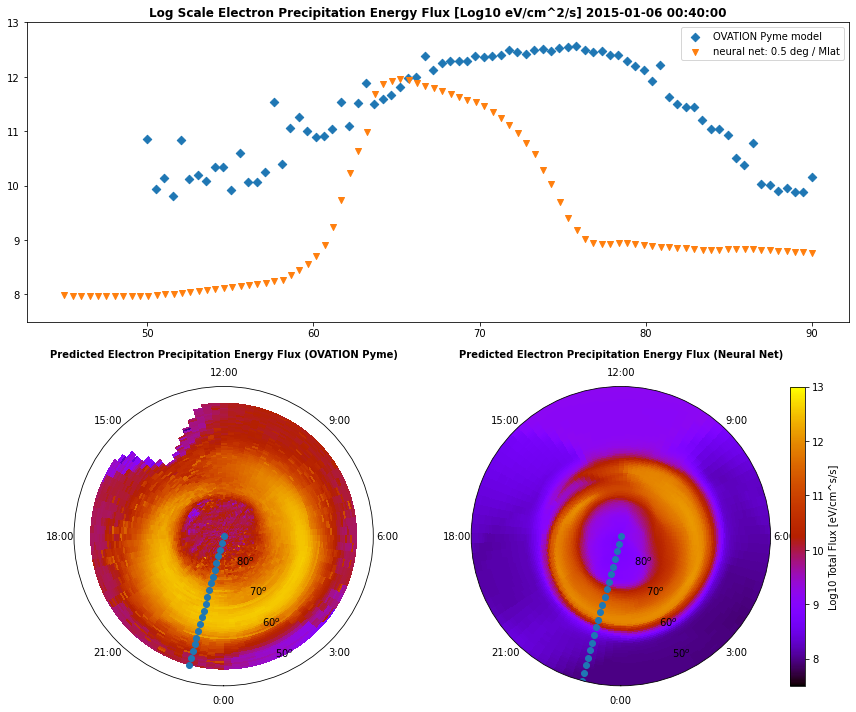

/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


2015-01-06 06:40:00
Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:516: RuntimeWarning: divide by zero encountered in log10


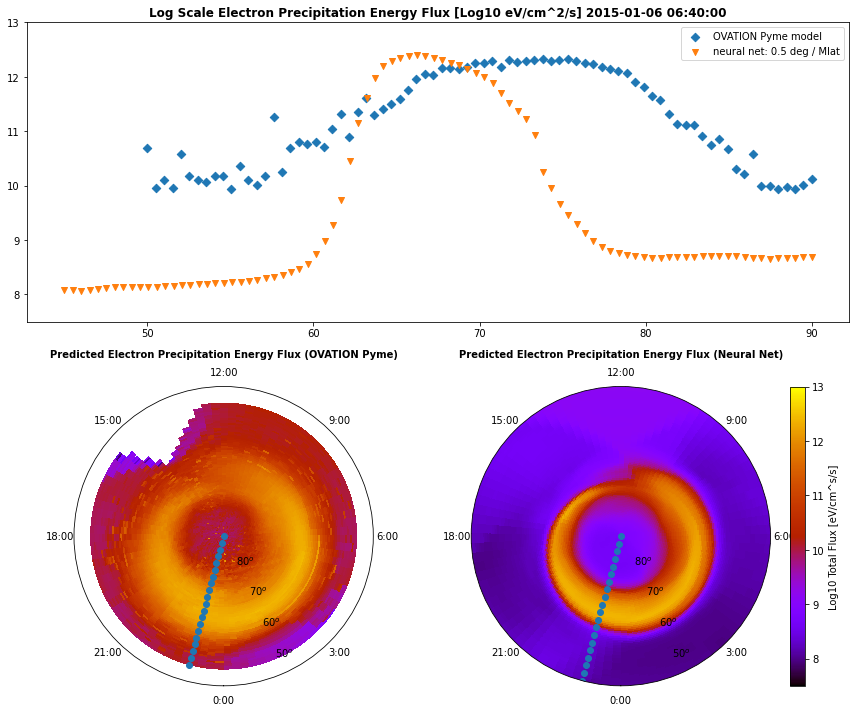

/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


2015-01-06 12:40:00
Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:516: RuntimeWarning: divide by zero encountered in log10


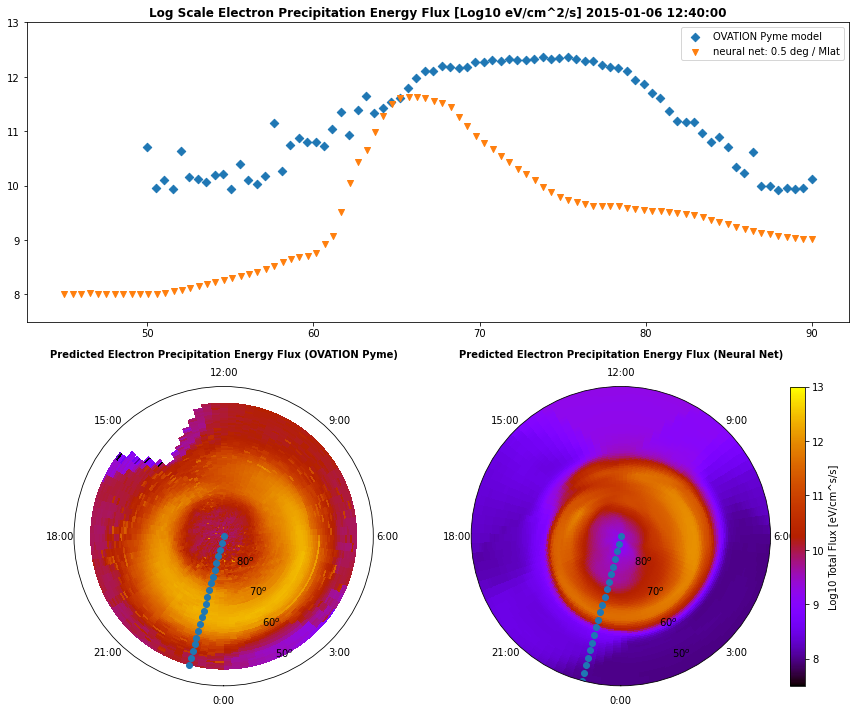

/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


2015-01-06 18:40:00
Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:516: RuntimeWarning: divide by zero encountered in log10


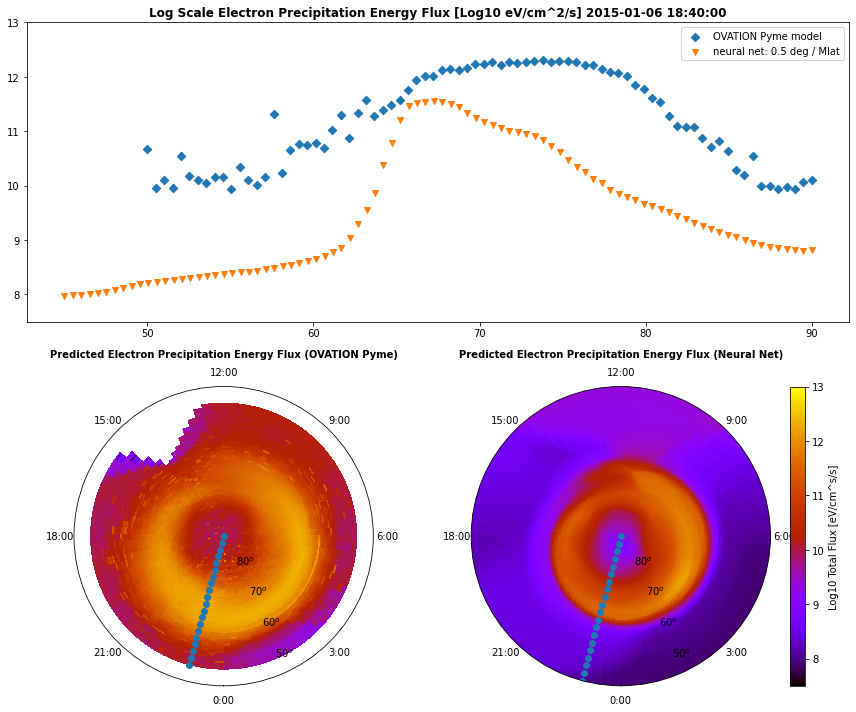

/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


2015-01-07 00:40:00
Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:516: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:549: RuntimeWarning: divide by zero encountered in log10


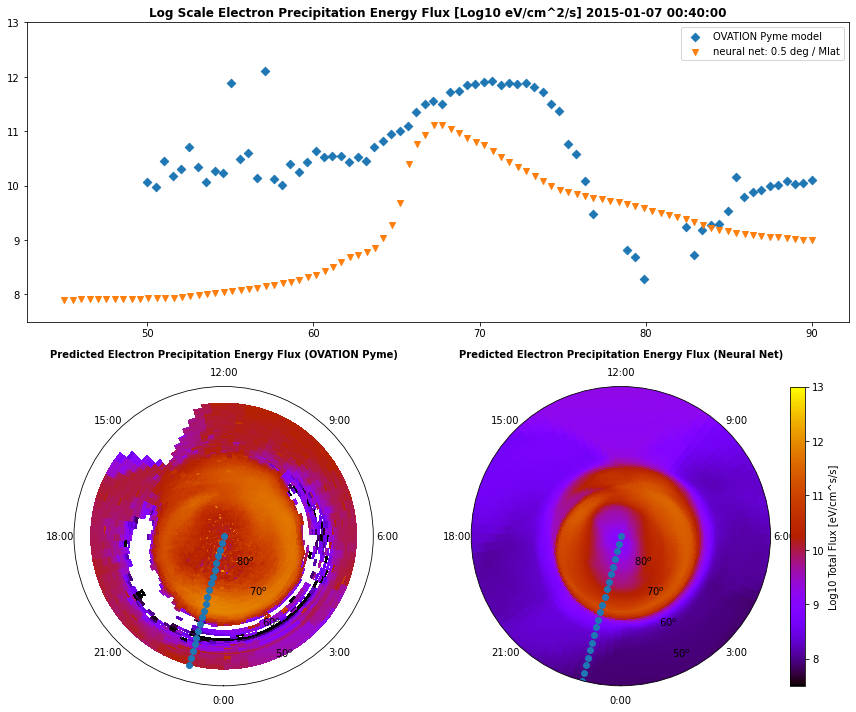

/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


2015-01-07 06:40:00
Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:516: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:549: RuntimeWarning: divide by zero encountered in log10


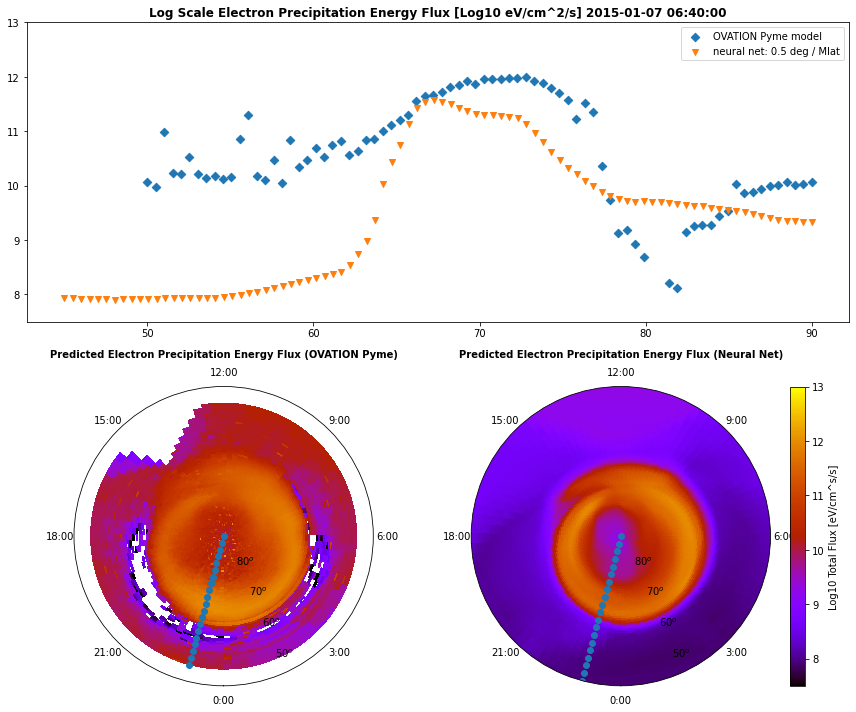

/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


2015-01-07 12:40:00
Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:516: RuntimeWarning: divide by zero encountered in log10


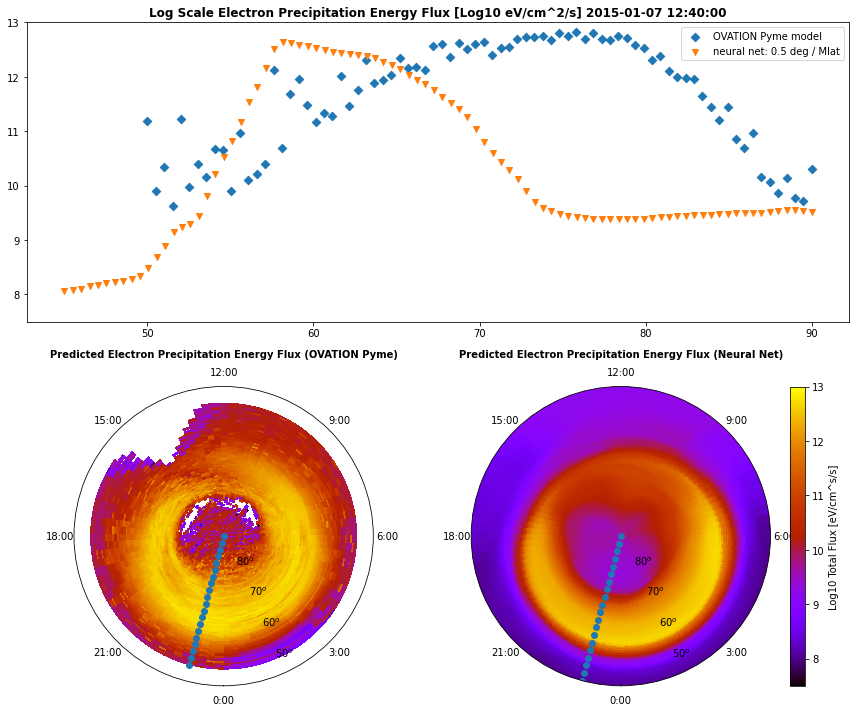

/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


2015-01-07 18:40:00
Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:516: RuntimeWarning: divide by zero encountered in log10


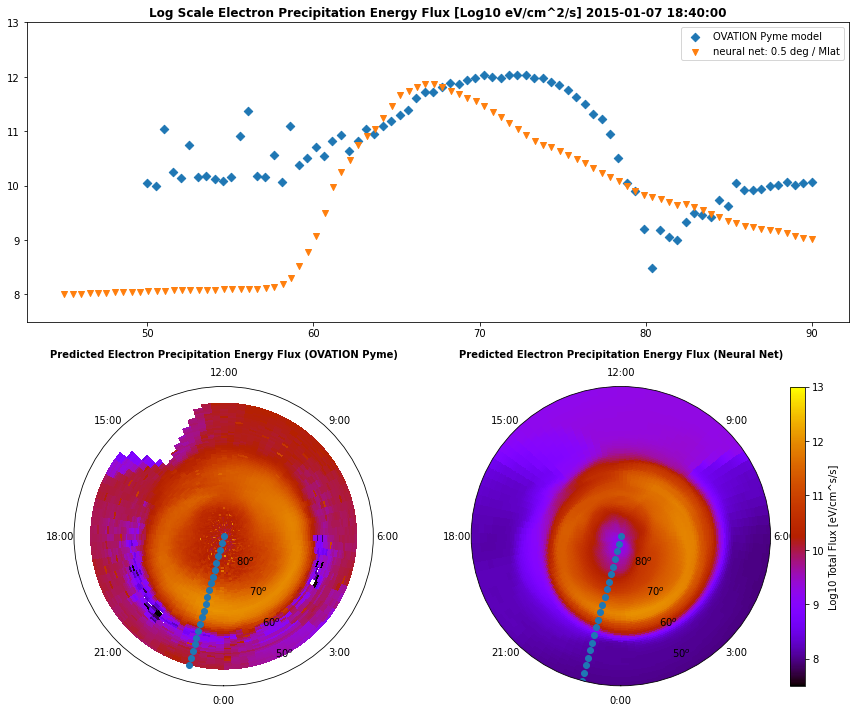

/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


2015-01-08 00:40:00
Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:516: RuntimeWarning: divide by zero encountered in log10


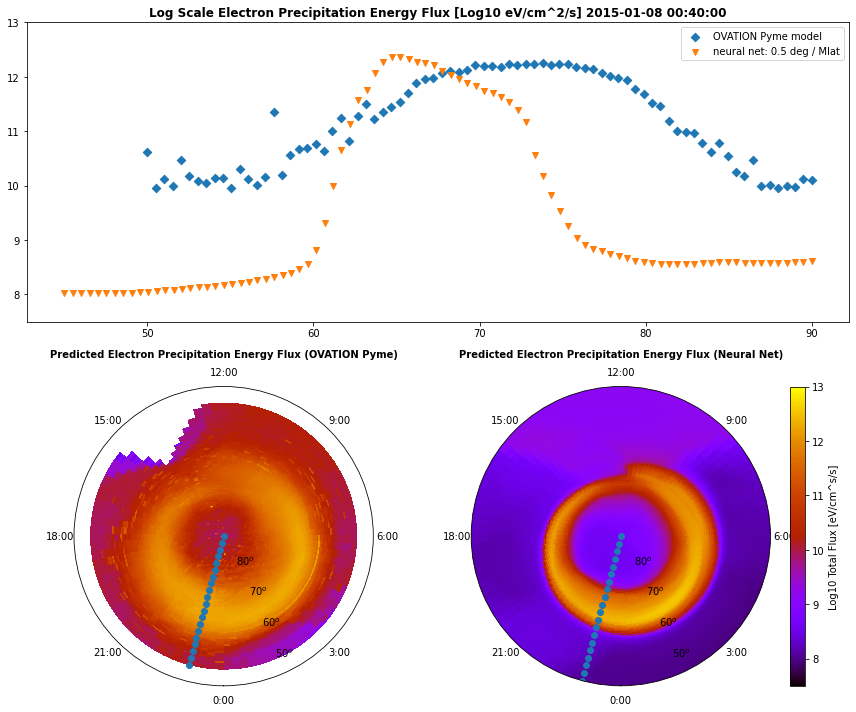

/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


2015-01-08 06:40:00
Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:516: RuntimeWarning: divide by zero encountered in log10


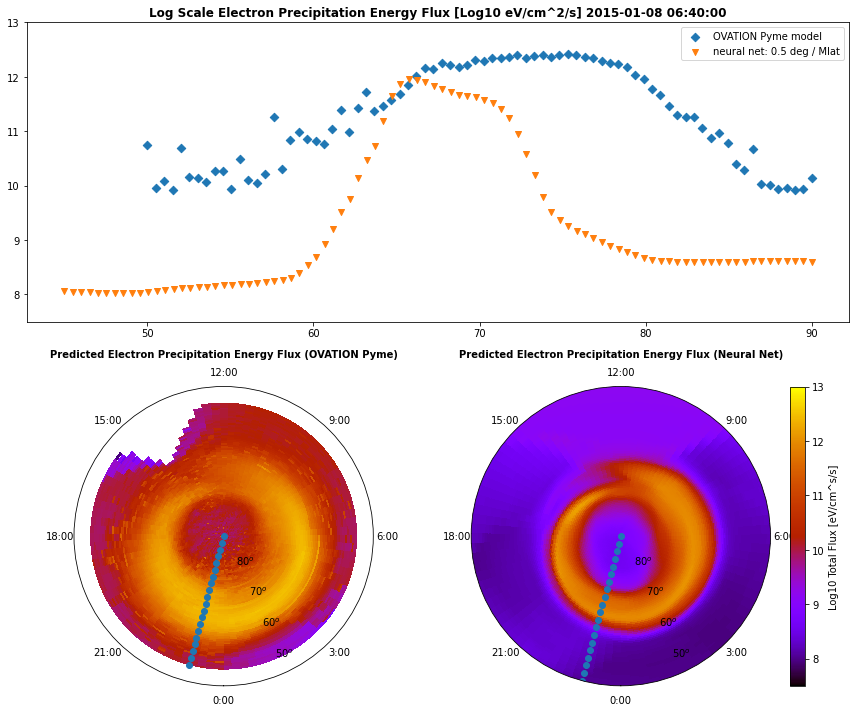

/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


2015-01-08 12:40:00
Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:516: RuntimeWarning: divide by zero encountered in log10


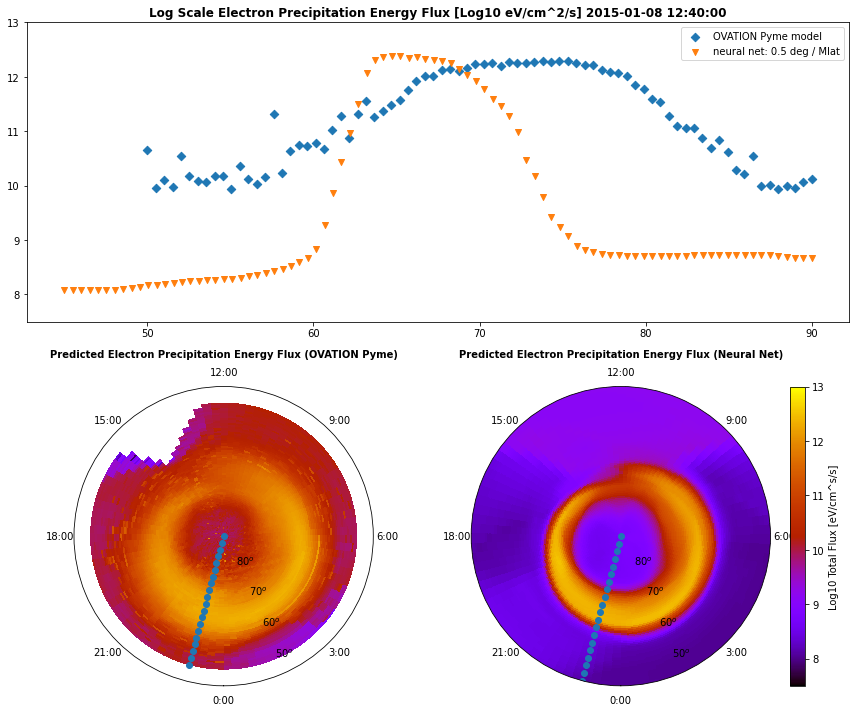

/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


2015-01-08 18:40:00
Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:516: RuntimeWarning: divide by zero encountered in log10


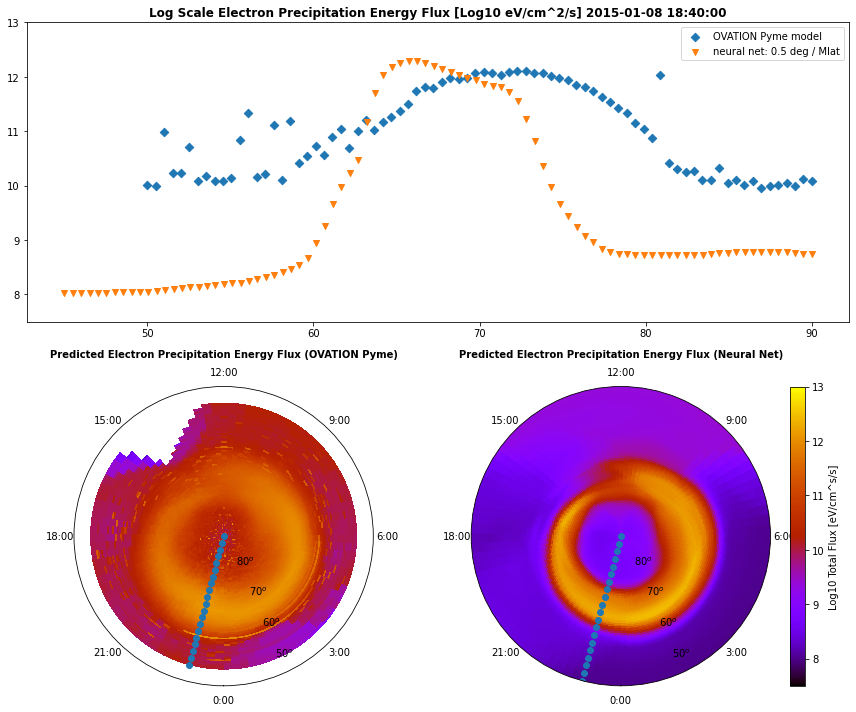

In [8]:
plot_hemisphere(scaler_X, model_energy, features, test_6_hour)

In [ ]:
plot_hemisphere2(scaler_X, model_energy, features, test10min)

In [ ]:
plot_hemisphere3(scaler_X, model_energy, features, test10min)

In [ ]:
plot_hemisphere4(scaler_X, model_energy, features, test10min)

In [17]:
# this is for the number flux model

def custom_loss(y_true, y_pred):
    

    loss = K.mean( 
        2.5*(y_true-y_pred)*(y_true-y_pred)
        *K.cast(K.greater(y_true,6.25),'float32')*K.cast(K.less_equal(y_pred,6.25),'float32') +
        5*(y_true-y_pred)*(y_true-y_pred) 
        *K.cast(K.greater(y_true,6.75),'float32')*K.cast(K.less_equal(y_pred,6.75),'float32') +
        10*(y_true-y_pred)*(y_true-y_pred)
        *K.cast(K.greater(y_true,7),'float32')*K.cast(K.less_equal(y_pred,7),'float32')  
        +
        10*(y_true-y_pred)*(y_true-y_pred)
        *K.cast(K.greater(y_true,7.25),'float32')*K.cast(K.less_equal(y_pred,7.25),'float32')  
        +
        10*(y_true-y_pred)*(y_true-y_pred)
        *K.cast(K.greater(y_true,7.5),'float32')*K.cast(K.less_equal(y_pred,7.5),'float32')  
    )             
                 
            
    loss =  loss+K.mean((y_true-y_pred)*(y_true-y_pred))

    return loss

filename='counts_tail_loss_new_pipeline_33'
model_number = tensorflow.keras.models.load_model(filename, custom_objects={'custom_loss': custom_loss})



In [ ]:
# evaluate the model at all times in the dataframe "test".  the output is for a data frame spanning many m_latitudes and m_local_times

ml_energy = plot_hemisphere_CSV(scaler_X, model_energy, features,test10min)

ml_counts = plot_hemisphere_CSV_counts(scaler_X, model_number, features,test10min)


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1147: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


In [ ]:
mlatgridN = np.linspace(90,45,num=90)
mltgridN =  np.linspace(0,24,num=96)  
df = pd.DataFrame(columns=['SC_AACGM_LAT_deg', 'SC_AACGM_LTIME_hr', 'ELE_TOTAL_ENERGY_FLUX_erg_per_cm2_s','ELE_TOTAL_COUNTS_#_per_cm2_s','time'])
#, index=test10min.index)

mlat = np.zeros((90,96))
mlt = np.zeros((90,96))
for j in range(0,90):
    for k in range(0,96):
        mlat[j,k] = mlatgridN[j]
        mlt[j,k] = mltgridN[k]


for i in range(0, test10min.shape[0] ):
    temp=np.column_stack( ( np.reshape(mlat,(90*96)),np.reshape(mlt,(90*96)),np.reshape(ml_energy[i],(90*96)),
                      np.reshape(ml_counts[i],(90*96)), np.repeat(test10min.index[i],90*96)  ) )
    df2 = pd.DataFrame(data = temp, columns=['SC_AACGM_LAT_deg', 'SC_AACGM_LTIME_hr', 'ELE_TOTAL_ENERGY_FLUX_erg_per_cm2_s','ELE_TOTAL_COUNTS_#_per_cm2_s','time'])

    df = pd.concat([df,df2])
df = df.set_index('time')
df.index = pd.to_datetime(df.index)

df.to_csv('data_jan_6-8_2015_hemisphere_10min_cadence.csv')

df

In [ ]:
60*60*24*3/600*90*96

In [ ]:
# evaluate the model at all times in the dataframe "test".  the output is for a data frame spanning many m_latitudes and m_local_times

ml_energy, ovation_energy = plot_hemisphere_CSV(scaler_X, model_energy, features,test10min)

ml_counts, ovation_counts = plot_hemisphere_CSV_counts(scaler_X, model_number, features,test10min)


In [ ]:
# n = 0
# mlatgridN = np.linspace(90,45,num=90)
# mltgridN =  np.linspace(0,24,num=96)  
# df = pd.DataFrame(columns=['SC_AACGM_LAT_deg', 'SC_AACGM_LTIME_hr', 'ELE_TOTAL_ENERGY_FLUX_erg_per_cm2_s','ELE_TOTAL_COUNTS_#_per_cm2_s','OVATION_ELE_TOTAL_ENERGY_FLUX_erg_per_cm2_s','OVATION_ELE_TOTAL_COUNTS_#_per_cm2_s','time'])
# #, index=test10min.index)
# for i in range(0, test10min.shape[0] ):
#     dt = test10min.index[i]
#     for j in range(0,90):
#         mlat = mlatgridN[j]
#         for k in range(0,96):
#             mlt = mltgridN[k]
#             if (j > 9):
#                 df.loc[n]=[mlat, mlt, ml_energy[i][j,k],ml_counts[i][j,k],ovation_energy[i][j-10,k],ovation_counts[i][j-10,k],dt]
#             else:
#                 df.loc[n]=[mlat, mlt, ml_energy[i][j,k],ml_counts[i][j,k],ovation_energy[i][0,k],ovation_counts[i][0,k],dt]
#             n=n+1
# df = df.set_index('time')
# df.index = pd.to_datetime(df.index)

# df.to_csv('data_jan_6-8_2015_with_ovation_hemisphere_10min_cadence.csv')

In [ ]:
mlatgridN = np.linspace(80,45,num=80)
mltgridN =  np.linspace(0,24,num=96)  
df = pd.DataFrame(columns=['SC_AACGM_LAT_deg', 'SC_AACGM_LTIME_hr', 'ELE_TOTAL_ENERGY_FLUX_erg_per_cm2_s','ELE_TOTAL_COUNTS_#_per_cm2_s','OVATION_ELE_TOTAL_ENERGY_FLUX_erg_per_cm2_s','OVATION_ELE_TOTAL_COUNTS_#_per_cm2_s','time'])
#, index=test10min.index)

mlat = np.zeros((80,96))
mlt = np.zeros((80,96))
for j in range(0,80):
    for k in range(0,96):
        mlat[j,k] = mlatgridN[j]
        mlt[j,k] = mltgridN[k]


for i in range(0, test10min.shape[0] ):
    
    temp=np.column_stack( ( np.reshape(mlat,(80*96)),np.reshape(mlt,(80*96)),np.reshape(ml_energy[i][0:80,:],(80*96)),
                      np.reshape(ml_counts[i][0:80,:],(80*96)),  np.reshape(ovation_energy[i],(80*96)),  np.reshape(ovation_counts[i],(80*96)), np.repeat(test10min.index[i],80*96)  ) )
    df2 = pd.DataFrame(data = temp,columns=['SC_AACGM_LAT_deg', 'SC_AACGM_LTIME_hr', 'ELE_TOTAL_ENERGY_FLUX_erg_per_cm2_s','ELE_TOTAL_COUNTS_#_per_cm2_s','OVATION_ELE_TOTAL_ENERGY_FLUX_erg_per_cm2_s','OVATION_ELE_TOTAL_COUNTS_#_per_cm2_s','time'])

    df = pd.concat([df,df2])
df = df.set_index('time')
df.index = pd.to_datetime(df.index)

df.to_csv('data_jan_6-8_2015_with_ovation_hemisphere_10min_cadence.csv')
df